In [1]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D



In [2]:
# Setup

c = np.load('casper/calib.npy',allow_pickle=True).item()
print(c)
K0 = c['K0']
K1 = c['K1']
d0 = c['d0']
d1 = c['d1']
R = c['R']
t = c['t']

n1 = 40
n2 = 41


{'K0': array([[1.09058826e+03, 0.00000000e+00, 4.22000000e+02],
       [0.00000000e+00, 1.09058826e+03, 3.38000000e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]), 'd0': array([-0.03720395, -0.2353958 ,  0.        ,  0.        ,  0.        ]), 'K1': array([[1.09454675e+03, 0.00000000e+00, 4.22000000e+02],
       [0.00000000e+00, 1.09454675e+03, 3.38000000e+02],
       [0.00000000e+00, 0.00000000e+00, 1.00000000e+00]]), 'd1': array([-0.04744541, -0.00026868,  0.        ,  0.        ,  0.        ]), 'R': array([[ 0.91398722, -0.07814026,  0.39814758],
       [ 0.07619891,  0.99687725,  0.02072451],
       [-0.39852369,  0.01139647,  0.91708726]]), 't': array([[-407.240143 ],
       [  -1.5053668],
       [  85.688652 ]])}


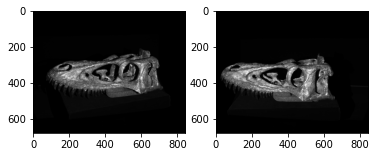

In [3]:
# Exercise 13.2
im0 = cv2.imread('casper/sequence/frames0_0.png')
'''
no_light_camera1 = cv2.imread('casper/sequence/frames0_1.png')
full_light_camera2 = cv2.imread('casper/sequence/frames1_0.png')
no_light_camera2 = cv2.imread('casper/sequence/frames1_1.png')
camera1_pattern1 = []
camera1_pattern2 = []
camera2_pattern1 = []
camera2_pattern2 = []
plt.imshow(no_light_camera1)
'''

size = (im0.shape[1], im0.shape[0])
stereo = cv2.stereoRectify(K0,d0,K1,d1,size,R,t,flags=0)
R0, R1, P0, P1 = stereo[:4]
maps0 = cv2.initUndistortRectifyMap(K0,d0,R0,P0,size,cv2.CV_32FC2)
maps1 = cv2.initUndistortRectifyMap(K1,d1,R1,P1,size,cv2.CV_32FC2)

ims0 = []
ims1 = []

for i in range(10):
    image1 = cv2.imread('casper/sequence/frames0_%01d.png' %i)
    image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    image1 = image1.astype(np.float32)
    ims0.append(image1)
    image2 = cv2.imread('casper/sequence/frames1_%01d.png' %i)
    image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
    image2 = image2.astype(np.float32)
    ims1.append(image2)

for i in range(10,26):
    image1 = cv2.imread('casper/sequence/frames0_%02d.png' %i)
    image1 = cv2.cvtColor(image1, cv2.COLOR_BGR2GRAY)
    image1 = image1.astype(np.float32)
    ims0.append(image1)
    image2 = cv2.imread('casper/sequence/frames1_%02d.png' %i)
    image2 = cv2.cvtColor(image2, cv2.COLOR_BGR2GRAY)
    image2 = image2.astype(np.float32)
    ims1.append(image2)

fig = plt.figure()
fig.add_subplot(1,2,1)
plt.imshow(ims0[0],cmap='gray')
fig.add_subplot(1,2,2)
plt.imshow(ims1[0],cmap='gray')

In [4]:
# Exercise 13.3
def unwrap(ims, n):
    primary = ims[2:18]
    fft_primary = np.fft.rfft(primary,axis=0)
    theta_primary = np.angle(fft_primary[1])
    secondary = ims[18:]
    fft_secondary = np.fft.rfft(secondary,axis=0)
    theta_secondary = np.angle(fft_secondary[1])
    theta_c = (theta_secondary - theta_primary) % (2*np.pi)
    o_primary = np.rint((n*theta_c-theta_primary)/(2*np.pi))
    theta = ((2*np.pi*o_primary+theta_primary)/(n))%(2*np.pi)
    return theta


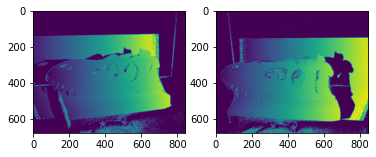

In [5]:
theta0 = unwrap(ims0,n1)
theta1 = unwrap(ims1,n1)
fig = plt.figure()
fig.add_subplot(1,2,1)
plt.imshow(theta0)
fig.add_subplot(1,2,2)
plt.imshow(theta1)

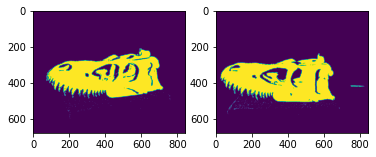

In [6]:
# Exercise 13.4
diff1 = ims0[0] - ims0[1]
diff2 = ims1[0] - ims1[1]
threshold = 15
mask0 = diff1 > threshold
mask1 = diff2 > threshold
fig = plt.figure()
fig.add_subplot(1,2,1)
plt.imshow(mask0)
fig.add_subplot(1,2,2)
plt.imshow(mask1)

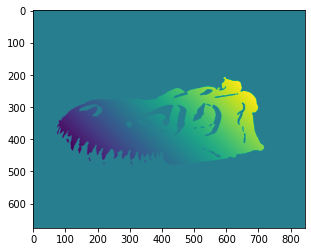

In [7]:
# Exercise 13.5

q0s = []
q1s = []
for i0 in range(size[1]):
    for j0 in range(size[0]):
        if mask0[i0,j0]:
            val1 = theta0[i0,j0]
            j = 0
            diff = np.inf
            for j1 in range(size[0]):
                
                if mask1[i0,j1]:
                    val2 = theta1[i0,j1]
                    if abs(val2-val1) < diff:
                        diff = abs(val2-val1)
                        j = j1
            q0s.append([j0,i0])
            q1s.append([j,i0])
                

disparity = np.zeros([size[1],size[0]])
for k in range(len(q0s)):
    disparity[q0s[k][1],q0s[k][0]] = q0s[k][0] - q1s[k][1]
    
disparity = cv2.medianBlur(disparity.astype(np.float32),5)
plt.imshow(disparity)


In [8]:
# Exercise 13.6
q0s = np.array(q0s).T
q1s = np.array(q1s).T
Q_hom = cv2.triangulatePoints(P0,P1,q0s,q1s)
#Q = Q_hom[:,-1]/Q_hom[-1]

print(Q_hom.shape)
print(type(Q_hom))

(4, 102756)
<class 'numpy.ndarray'>


In [ ]:
Q = Q_hom[:,:-1]/Q_hom[:,-1]

In [9]:
print(Q_hom)

[[ 1653466727  1069670267  1653466727 ...  1069670267  1653466727
   1069670267]
 [ 1653466727  1069670267  1653466727 ...  1069670267  1653466727
   1069670267]
 [ 1156512900  1070756977  1156512900 ...  1070756977  1156512900
   1070756977]
 [ -953098107 -1074900949  -953098107 ... -1074900949  -953098107
  -1074900949]]


In [ ]:
fig = plt.figure()
ax = fig.add_subplot(111,projection='3d')
ax.scatter(Q[0,:],Q[1,:],Q[2,:])
plt.show()